
Problem Statement :
We’ve all been the recipient of spam emails before. Spam mail, or junk mail, is a type of email
that is sent to a massive number of users at one time, frequently containing cryptic
messages, scams, or most dangerously, phishing content.



In this Project, use Python to build an email spam detector. Then, use machine learning to
train the spam detector to recognize and classify emails into spam and non-spam. Let’s get
started!

download dataset using this link : https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset/

data description : The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate)/Not-spam or spam.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
import os
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load dataset from csv file and use encoding as latin-1
email_df=pd.read_csv(r"email_spam_detection_dataset.csv",encoding='latin-1')

In [3]:
#print first 5 records
email_df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
#print concise summary about dataset.
email_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
#lets delete Unnamed : 2 , Unnamed : 3 and Unnamed : 4 column because they are having zero values in almost entire column.
column_to_delete=[name for name in email_df.columns if name.startswith('Unnamed')]
email_df.drop(columns=column_to_delete,inplace=True)

In [6]:
#rename v1 column to target and v2 column to message
email_df.rename(columns=dict({"v1":"target","v2":"message"}),inplace=True)

In [7]:
#after deleting and renaming columns print last 5 records of the dataset
email_df.tail()

,target,message
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


In [8]:
#print null values
email_df.isnull().sum()

target     0
message    0
dtype: int64

In [9]:
#print no of duplicate records
print("Total duplicated records in dataset are : {}".format(email_df.duplicated().sum()))

Total duplicated records in dataset are : 403


In [10]:
#lets remove duplicated records
email_df.drop_duplicates(inplace=True)

# Data Preprocessing :
        1. target : map spam to 0 and ham/not-spam to 1
        2. message : 1. lower case
                     2. tokenization
                     3. remove stop words and punctuation
                     4. stemizing : reduce the word to its root form.

In [11]:
#function to map target with 0 and 1
def target_mapper(text):
    return 0 if text=='spam' else 1

email_df["target"]=email_df['target'].apply(func=target_mapper)

In [12]:
#import nltk library for data preprocessing
import nltk
nltk.download('punkt') #download punctuation
nltk.download('stopwords') #download stopwords
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk import tokenize  #import nltk tokenize package to use word and sentence tokenizer.
STOPWORDS=stopwords.words("english") #taking only english stopwords because spam messages are in english language only.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
#function to preprocess row text into ready to use format for our model.
def message_tranformation(text):
    text=text.strip() #remove black spaces from starting and ending of message text
    text=text.lower() #coverting all message words into lowercase format to generalize it.

    #tokenize the text
    words=tokenize.word_tokenize(text)

    #intialize the porter stemmer
    stemmer=PorterStemmer()

    #remove stopwords and applying stemming while ignoring special words.
    filtered_words=[stemmer.stem(word) for word in words if word not in STOPWORDS and word.isalnum()]

    #Join list of filter words back to the string format
    transformed_text=" ".join(filtered_words)
    return transformed_text

In [14]:
#applying message tranformation function on email_df transformed_message column.
email_df["transformed_message"]=email_df["message"].apply(message_tranformation)

In [15]:
#print first 5 recods after cleaning messages
email_df.head()

,target,message,transformed_message
0,1,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,1,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,0,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...
3,1,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,1,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though


In [16]:
#now we can delete message column because we are going to work with preprocessed text messages only.
email_df.drop(columns="message",inplace=True)

In [17]:
#configure object of wordcloud plot
from wordcloud import WordCloud
wc=WordCloud(width=1000,height=1000,min_font_size=8,background_color='white')

Wordcloud for Spam Category messaages

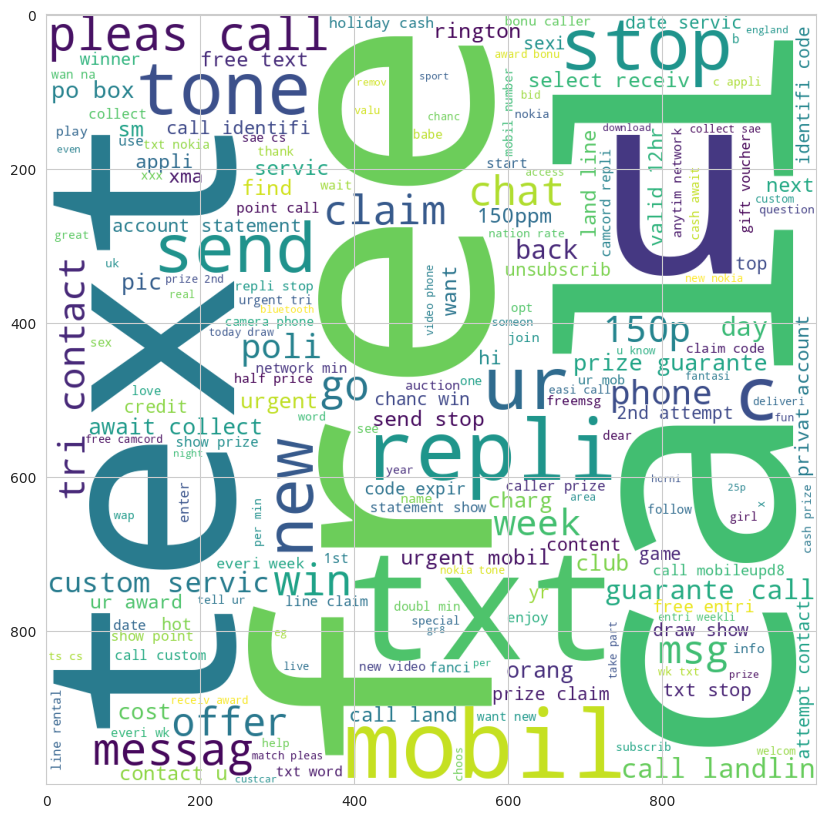

In [18]:
#generate wordcloud plot for spam messages
spam_wc=wc.generate(email_df[email_df["target"]==0]["transformed_message"].str.cat(sep=" "))
plt.figure(figsize=(20,10))
plt.imshow(spam_wc)
plt.show()

Wordcloud of ham category

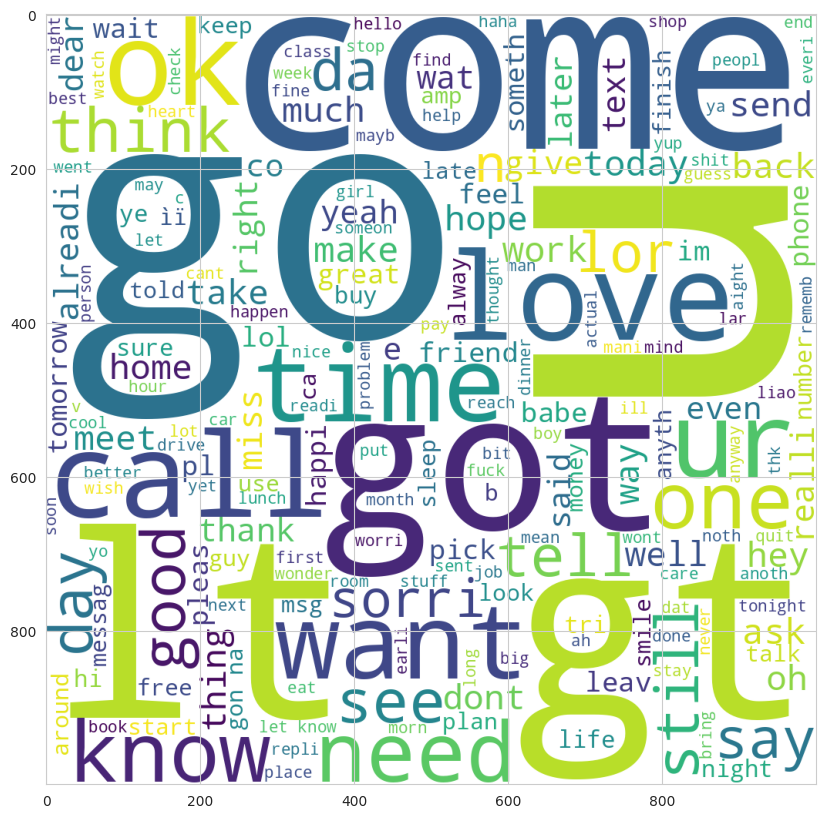

In [19]:
#generate wordcloud plot for not-spam messages
ham_wc=wc.generate(email_df[email_df["target"]==1]["transformed_message"].str.cat(sep=" "))
plt.figure(figsize=(20,10))
plt.imshow(ham_wc)
plt.show()

In [20]:
#used words in spam messages
spam_corpus=list()
for msg in email_df[email_df['target']==0]["transformed_message"].to_list():
    for word in msg.split():
        spam_corpus.append(word)

In [21]:
len(spam_corpus)

9939

In [22]:
#print the most common 50 words from the spam category messages
from collections import Counter
spam_top_50_common_words=pd.DataFrame(Counter(spam_corpus).most_common(50))
print(spam_top_50_common_words)

           0    1
0       call  320
1       free  191
2          2  155
3        txt  141
4       text  122
5          u  119
6         ur  119
7      mobil  114
8       stop  104
9      repli  103
10     claim   98
11         4   97
12     prize   82
13       get   74
14       new   64
15    servic   64
16      tone   63
17      send   60
18    urgent   57
19     nokia   57
20   contact   56
21     award   55
22     phone   52
23      cash   51
24     pleas   51
25      week   49
26       win   48
27         c   45
28   collect   45
29       min   45
30    custom   42
31    messag   42
32  guarante   42
33       per   41
34      chat   38
35       tri   37
36       msg   35
37      draw   35
38    number   35
39        cs   35
40      show   33
41     today   33
42     offer   33
43      line   33
44        go   32
45    receiv   31
46      want   31
47    latest   30
48   rington   30
49   landlin   30


In [23]:
#used words in ham messages
ham_corpus=list()
for msg in email_df[email_df['target']==1]["transformed_message"].to_list():
    for word in msg.split():
        ham_corpus.append(word)

In [24]:
len(ham_corpus)

35404

In [25]:
#most commnaly used 50 words from ham category messages
ham_top_50_common_words=pd.DataFrame(Counter(ham_corpus).most_common(50))
print(ham_top_50_common_words)

        0    1
0       u  883
1      go  404
2     get  349
3      gt  288
4      lt  287
5       2  284
6    come  275
7     got  236
8    know  236
9    like  234
10   call  233
11   time  219
12     ok  217
13   love  216
14   good  213
15   want  208
16     ur  197
17    day  190
18   need  170
19    one  165
20    lor  159
21      4  156
22   home  152
23  think  149
24    see  147
25   take  143
26  still  143
27     da  142
28   tell  133
29   make  129
30    say  127
31   back  127
32  today  123
33   hope  122
34    ask  121
35  sorri  121
36      n  120
37   send  120
38      r  120
39   work  118
40   dont  118
41   meet  112
42     hi  111
43   well  109
44  thing  109
45    wat  108
46      k  107
47   much  107
48  night  107
49     oh  106


# Data Transformation
    Using Count Vectorization

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
cVector=CountVectorizer() #CountVectorizer is used to convert text into numeric array
x=cVector.fit_transform(email_df["transformed_message"]).toarray()

In [27]:
#seperating target column
y=email_df['target']

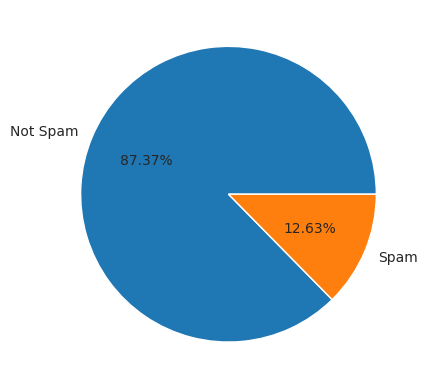

In [28]:
#check the distribution of target variable using Pie chart
plt.pie(y.value_counts().values,labels=["Not Spam","Spam"],autopct="%0.2f%%")
plt.show()

Conclusion : as we can see our dataset is imbalanced.

# Spliting data into Training and Testing sets into 80/20 ratio

In [29]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=43)
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((4135, 6708), (4135,), (1034, 6708), (1034,))

In [30]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report

#function to evaluate the performance of model
def evaluate_model_performance(model,x_test,y_test):
    y_pred=model.predict(x_test)
    print("Accurary Score : {}".format(np.round(accuracy_score(y_test,y_pred)*100,decimals=2)))
    print("Precision Score : {}".format(np.round(precision_score(y_test,y_pred)*100,decimals=2)))
    print("Recall Score : {}".format(np.round(recall_score(y_test,y_pred)*100,decimals=2)))
    print("F1 Score : {}".format(np.round(f1_score(y_test,y_pred)*100,decimals=2)))
    cm=confusion_matrix(y_test,y_pred)
    sns.heatmap(cm,fmt="d",annot=True,cmap="rainbow")
    plt.show()
    print("*Classification Report*********************************************")
    print(classification_report(y_test,y_pred))

In [31]:
#import models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

lr  :  94.6
nb  :  97.6
svm  :  89.2
knn  :  85.8
cart  :  91.4
rf  :  92.2
ad  :  94.0
gb  :  94.4
xgbc  :  93.8


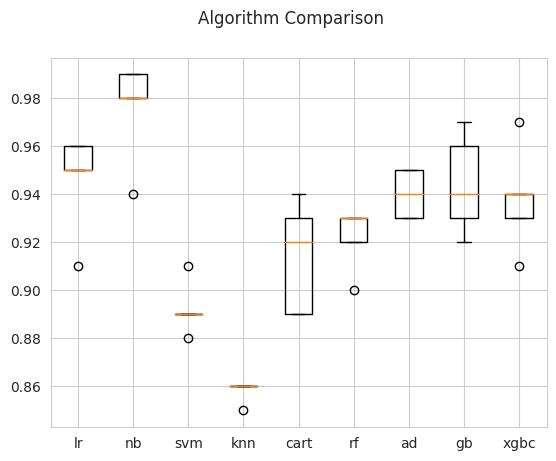

In [32]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler

# Define models
models = {
    "lr":LogisticRegression(),
    "nb":MultinomialNB(),
    "svm":SVC(),
    "knn":KNeighborsClassifier(),
    "cart":DecisionTreeClassifier(),
    "rf":RandomForestClassifier(),
    "ad":AdaBoostClassifier(),
    "gb":GradientBoostingClassifier(),
    "xgbc":XGBClassifier()
}

# Define oversampler for dealing with imbalance
oversampler = RandomOverSampler()

# Define cross-validation strategy for imbalanced data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model_scores=list()
# Loop through each model and evaluate its performance
for model_name, model in models.items():
    # Apply oversampling to training data
    X_resampled, y_resampled = oversampler.fit_resample(x, y)

    # Perform cross-validation
    scores = cross_val_score(model, X_resampled[:500], y_resampled[:500], cv=cv, scoring="f1_micro")
    print(model_name," : ",np.round(np.mean(scores)*100,decimals=2))
    model_scores.append(scores)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(model_scores)
ax.set_xticklabels(models.keys())
plt.show()

Conclusion : by analysing the performance of all base models we can say naive bayes and GradientBoostingClassifier are best for out dataset so here i am going to consider naive bayes as final out of all models.

In [33]:
#training our final Multinomial Naive Bayes model
model=MultinomialNB()
model.fit(x_train,y_train)
print("Model Training score : ",model.score(x_train,y_train))

Model Training score :  0.992503022974607


Accurary Score : 97.97
Precision Score : 98.88
Recall Score : 98.77
F1 Score : 98.83


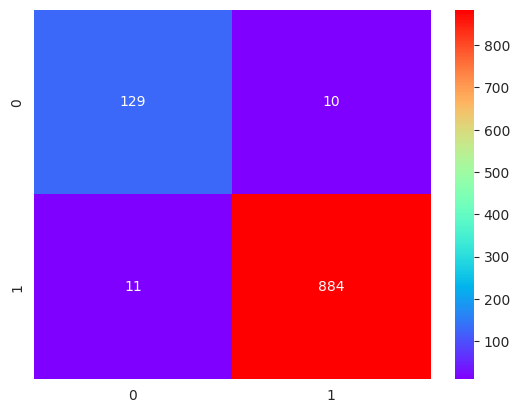

*Classification Report*********************************************
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       139
           1       0.99      0.99      0.99       895

    accuracy                           0.98      1034
   macro avg       0.96      0.96      0.96      1034
weighted avg       0.98      0.98      0.98      1034



In [34]:
#model performance
evaluate_model_performance(model,x_test,y_test)